In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer-dataset/sample_submission.csv
/kaggle/input/digit-recognizer-dataset/train.csv
/kaggle/input/digit-recognizer-dataset/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [3]:
train = pd.read_csv('../input/digit-recognizer-dataset/train.csv')
test = pd.read_csv('../input/digit-recognizer-dataset/test.csv')
print(train.shape)
test.shape
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y_train = train['label']
X_train = train.drop(['label'], axis=1)

In [5]:
test = test / 255.0
X_train = X_train / 255.0

In [6]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [7]:
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [8]:
Y_train = to_categorical(Y_train, num_classes = 10) # Encodes labels to one hot vectors

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2) # Jesus christ jordan you spent 3 hours on and off on a problem that had to do with not setting a seed
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


In [10]:
# ENSEMBLER STARTS
from tensorflow.keras.layers import BatchNormalization

In [11]:
from keras.optimizers import RMSprop, Adam
from keras.layers import DepthwiseConv2D, Reshape, Activation

nets = 25
model = [0] *nets

for z in range(nets):
    model[z] = Sequential()

    model[z].add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
    model[z].add(BatchNormalization())

    model[z].add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model[z].add(BatchNormalization())

    model[z].add(MaxPool2D(pool_size=(2,2)))
    model[z].add(Dropout(0.25))

    model[z].add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model[z].add(BatchNormalization())

    model[z].add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model[z].add(BatchNormalization())
    model[z].add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model[z].add(Dropout(0.25))

    model[z].add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
    model[z].add(BatchNormalization())
    model[z].add(Dropout(0.25))

    model[z].add(Flatten())
    model[z].add(Dense(256, activation = "relu"))
    model[z].add(BatchNormalization())
    model[z].add(Dropout(0.25))

    model[z].add(Dense(10, activation = "softmax"))
    
    model[z].compile(optimizer='RMSProp', loss="categorical_crossentropy", metrics=["accuracy"])
    
print('All models defined :)')

All models defined :)


In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
# train for 20 epochs
history = [0] * nets
epochs = 25

datagen = ImageDataGenerator(rotation_range=13, zoom_range=0.11, width_shift_range=0.1, height_shift_range=0.1)

datagen.fit(X_train)

for z in range(nets):
    print(f'Individual Net : {z+1}')   
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.01)
    history[z] = model[z].fit(datagen.flow(X_train2,Y_train2, batch_size=64), epochs = epochs, steps_per_epoch = X_train2.shape[0]//64, validation_data = (X_val2,Y_val2), callbacks=[learning_rate_reduction], verbose=1)

    print("CNN Model {0:d}: Epochs={1:d}, Training accuracy={2:.5f}, Validation accuracy={3:.5f}".format(z+1,epochs,max(history[z].history['accuracy']),max(history[z].history['val_accuracy']) ))

Individual Net : 1
Epoch 1/25
584/584 [==============================] - 17s 22ms/step - loss: 0.4998 - accuracy: 0.8490 - val_loss: 0.0701 - val_accuracy: 0.9815
Epoch 2/25
584/584 [==============================] - 12s 21ms/step - loss: 0.0904 - accuracy: 0.9712 - val_loss: 0.0939 - val_accuracy: 0.9762
Epoch 3/25
584/584 [==============================] - 13s 22ms/step - loss: 0.0714 - accuracy: 0.9781 - val_loss: 0.0437 - val_accuracy: 0.9868
Epoch 4/25
584/584 [==============================] - 12s 20ms/step - loss: 0.0571 - accuracy: 0.9830 - val_loss: 0.1034 - val_accuracy: 0.9762
Epoch 5/25
584/584 [==============================] - 12s 21ms/step - loss: 0.0462 - accuracy: 0.9867 - val_loss: 0.0727 - val_accuracy: 0.9841
Epoch 6/25
584/584 [==============================] - 13s 21ms/step - loss: 0.0505 - accuracy: 0.9854 - val_loss: 0.0802 - val_accuracy: 0.9868
Epoch 7/25
584/584 [==============================] - 12s 21ms/step - loss: 0.0401 - accuracy: 0.9877 - val_loss: 0.0

In [14]:
resultz = np.zeros( (test.shape[0],10) ) 
for z in range(nets):
    resultz = resultz + model[z].predict(test)
 
resultz = np.argmax(resultz,axis = 1)

In [15]:
resultz = pd.Series(resultz,name="Label")

In [16]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),resultz],axis = 1)

submission.to_csv("ensembleRM2525_01.csv",index=False)

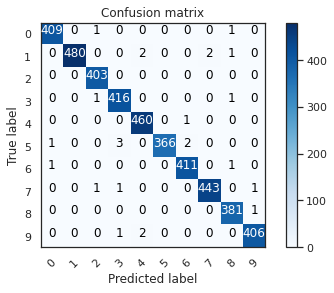

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model[z].predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [18]:
# ENSEMBLER ENDS!!! WOOOOOOOOO I GOT IT TO WORK LETS GOOOOO

NameError: name 'results' is not defined

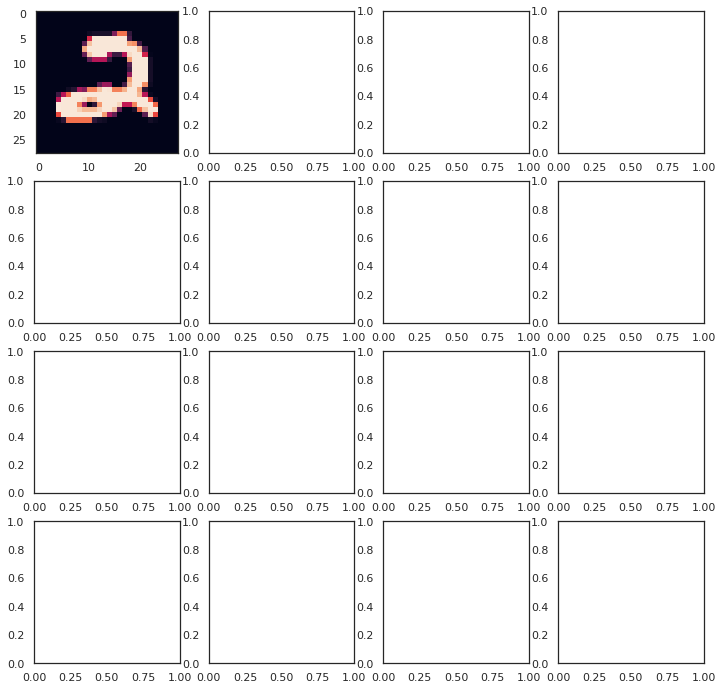

In [19]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(test[i].reshape(28,28))
    axes[i].set_title(results[i])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [20]:
# Thank you https://analyticsindiamag.com/hands-on-guide-to-create-ensemble-of-convolutional-neural-networks/

In [21]:
# Single model VV

In [22]:
from tensorflow.keras.layers import BatchNormalization
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_150 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_151 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 14, 14, 64)      

In [23]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [24]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [26]:
epochs = 50
batch_size = 86

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [28]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
439/439 [==============================] - 14s 29ms/step - loss: 0.5098 - accuracy: 0.8424 - val_loss: 1.1902 - val_accuracy: 0.6736
Epoch 2/50
439/439 [==============================] - 12s 27ms/step - loss: 0.0874 - accuracy: 0.9740 - val_loss: 0.0398 - val_accuracy: 0.9898
Epoch 3/50
439/439 [==============================] - 12s 28ms/step - loss: 0.0659 - accuracy: 0.9802 - val_loss: 0.0300 - val_accuracy: 0.9910
Epoch 4/50
439/439 [==============================] - 12s 26ms/step - loss: 0.0558 - accuracy: 0.9828 - val_loss: 0.0561 - val_accuracy: 0.9850
Epoch 5/50
439/439 [==============================] - 12s 26ms/step - loss: 0.0434 - accuracy: 0.9867 - val_loss: 0.0325 - val_accuracy: 0.9910
Epoch 6/50
439/439 [==============================] - 12s 27ms/step - loss: 0.0398 - accuracy: 0.9879 - val_loss: 0.0292 - val_accuracy: 0.9910
Epoch 7/50
439/439 [==============================] - 12s 26ms/step - loss: 0.0393 - accuracy: 0.9886 - val_loss: 0.0300 - val_accuracy:

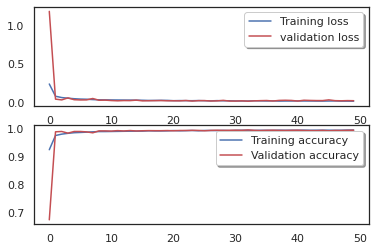

In [29]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

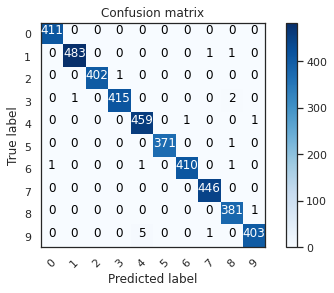

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

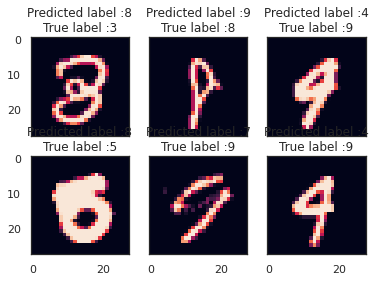

In [31]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [32]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [33]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen4.csv",index=False)